# <center>EDA of Drinking Water Quality Testing <br>in Palm Beach County </br>from 2019 through 2023
### <center>Exploratory data analysis with visualizations

In this EDA, we will look at results of tests of drinking water sampled around Palm Beach County from 2019 through 2023. This data comes from the Drinking Water Database managed by the Florida Department of Environmental Protection (DEP). It can be accessed here: https://floridadep.gov/water/source-drinking-water/content/information-drinking-water-database

The following information about the Florida DEP and their Drinking Water Database is copied from their website:
"The Department of Environmental Protection has the primary role of regulating public water systems in Florida... A public water system is one that provides water to 25 or more people for at least 60 days each year or serves 15 or more service connections. These public water systems may be publicly or privately owned and operated."

The Drinking Water Database includes "information on sample results, average/max monthly flows, types of water treatment, the type of system, address, capacity, sources of water, population and service connections served, dates the department performed the last sanitary survey, and the dates the last bacteria and inorganic/organic contaminant testing was performed." This information is available in five distinct reports, which the DEP has named "Basic Facility Reports," "Chemical Data," "Microbiological Data," "Flow Data," and "Plant Treatment Data."

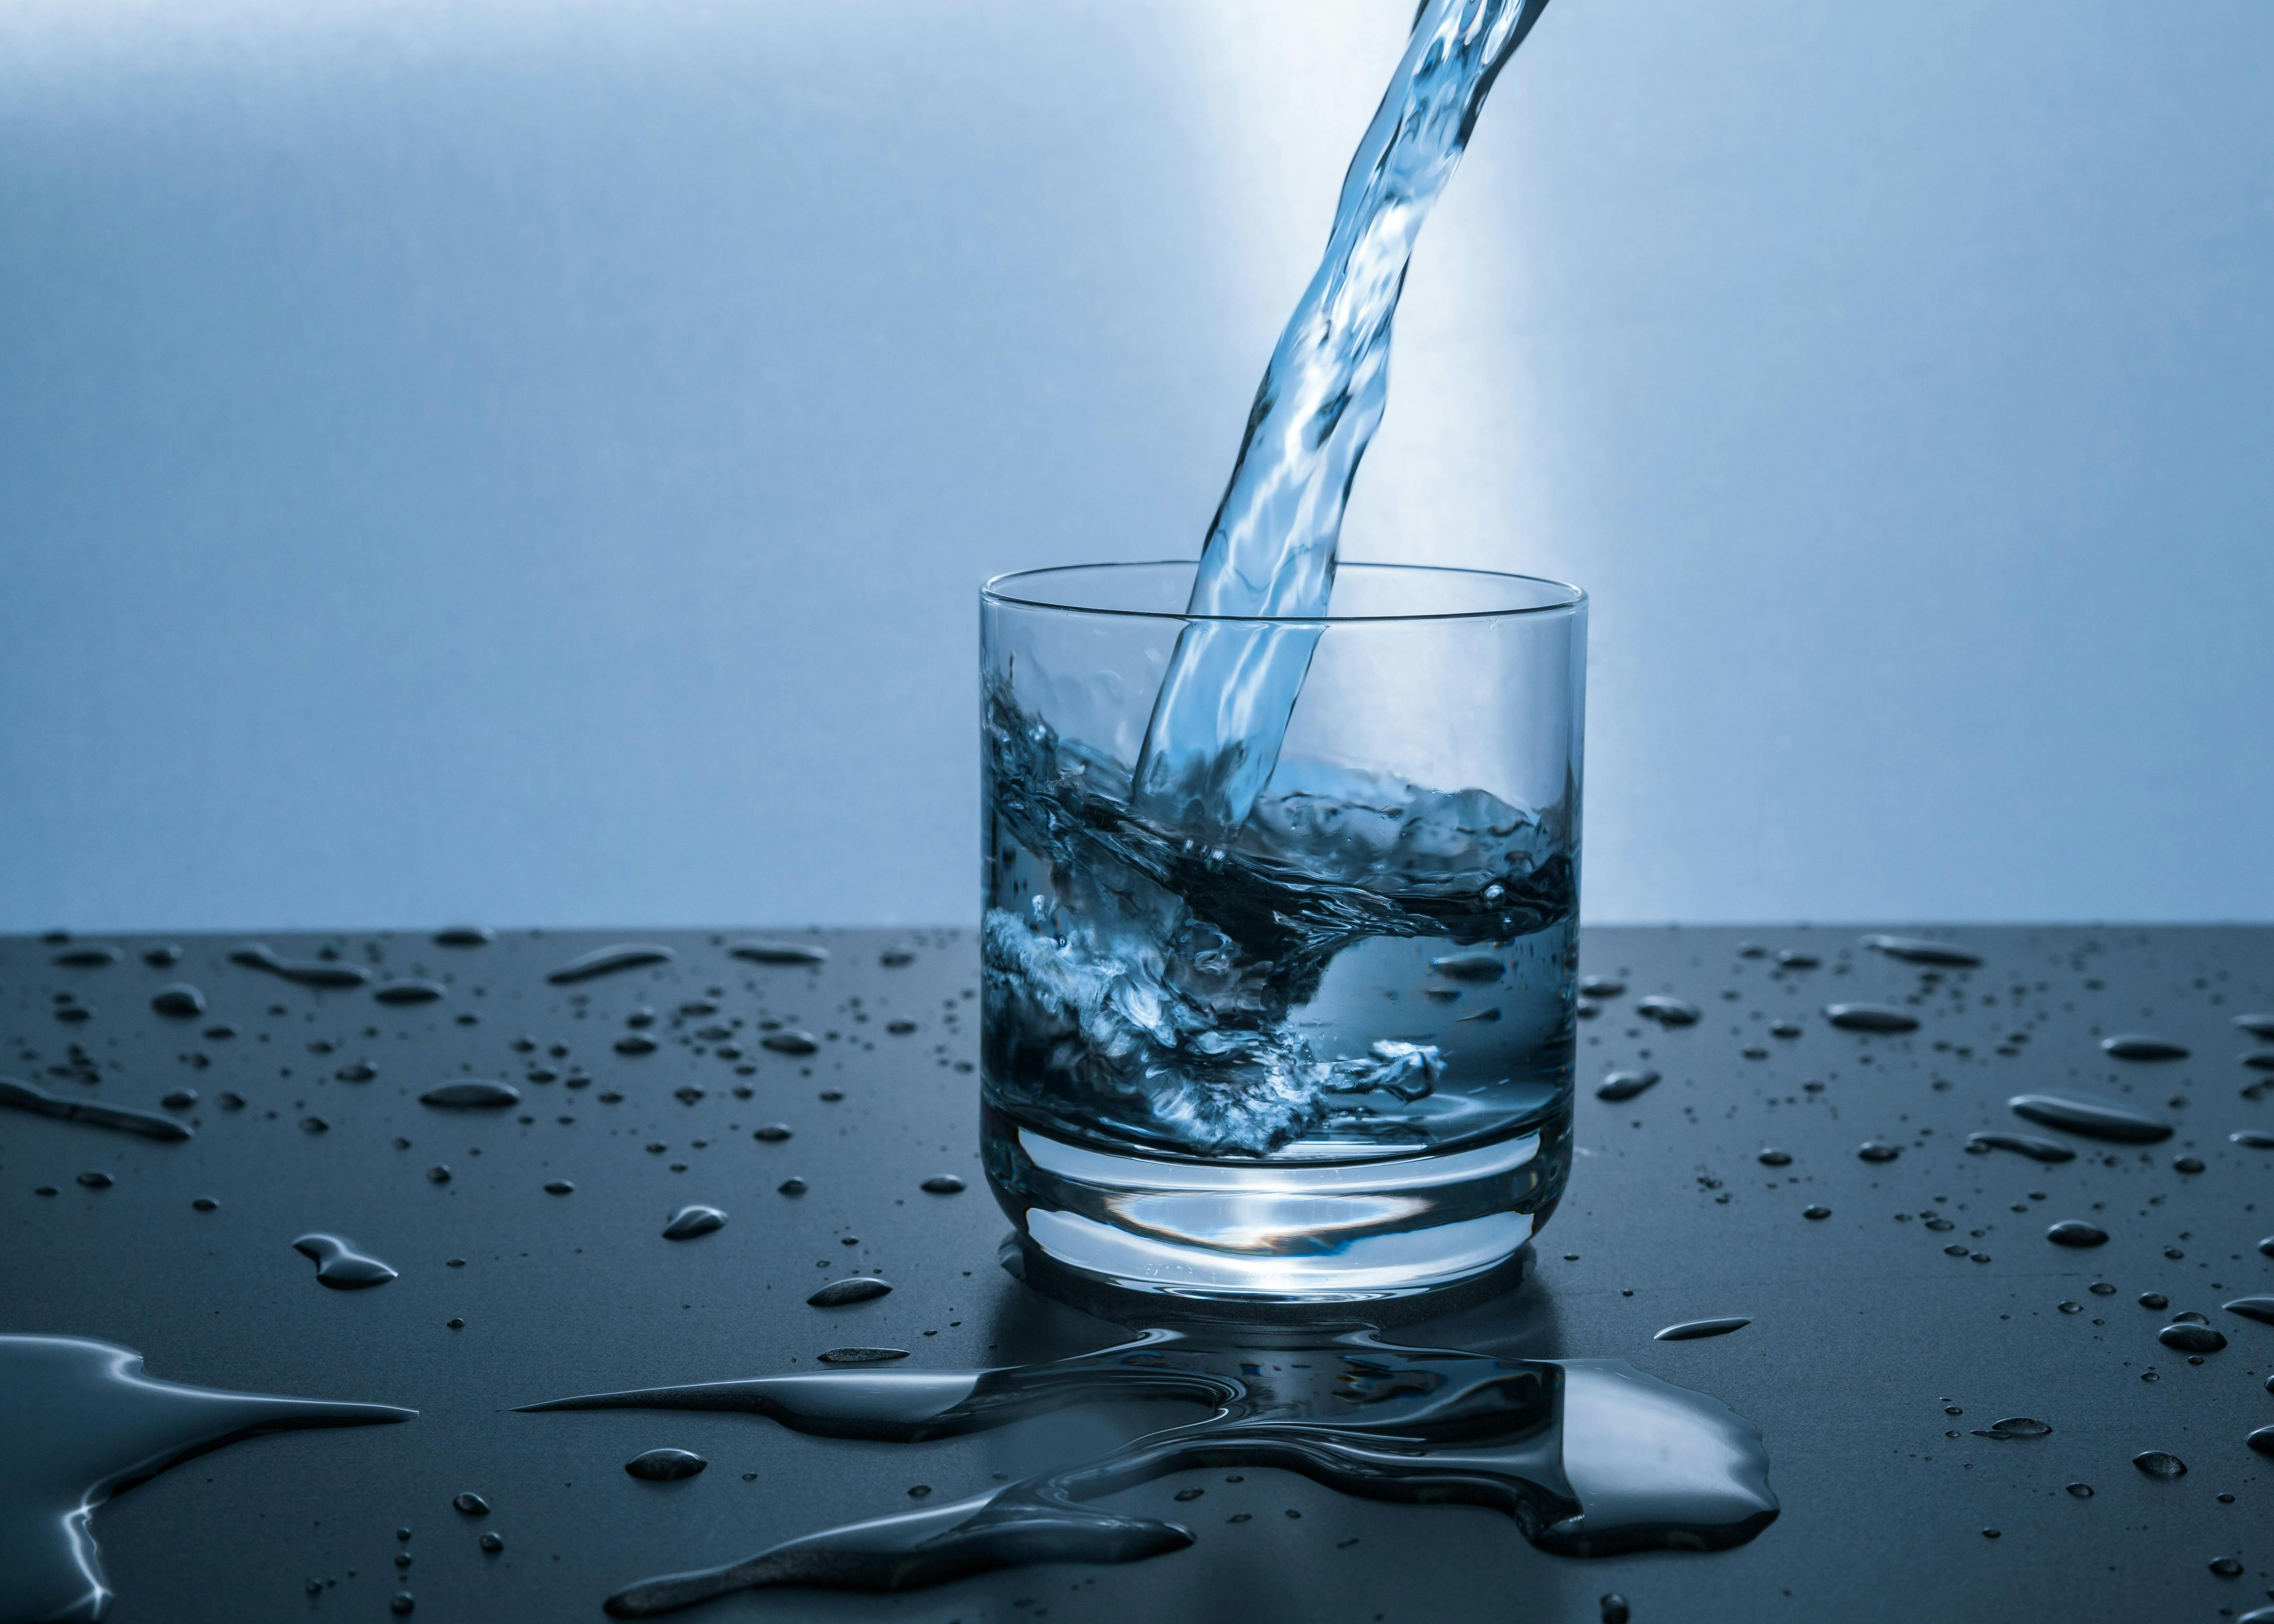

In [15]:
from IPython.display import display, Image
display(Image('data/water_img.jpg'))

After exploring the website and looking at some of the reports, I decided to focus this EDA on levels of contaminants in the drinking water tests. There are dozens of germs and chemicals that could contaminate our drinking water. According to the United States Center for Disease Control, the chemicals that most often contaminate tap water and cause disease are Arsenic, Copper, Lead, Nitrate, and Radon (https://www.cdc.gov/healthywater/drinking/contamination/chemicals.html). We will look at Arsenic, Copper, Lead, and Nitrate levels in drinking water around Palm Beach County, Florida. For the rest of this analysis, I will refer to these four chemicals as our contaminants of interest.

## <center>Objectives

<blockquote>My two main objectives are to:
<br>1. Identify elevated levels of chemical contaminants in drinking water tests
<br>2. Map testing locations around Palm Beach County</blockquote>

Results of testing for our contaminants of interest are available in the Florida DEP's "Chemical Data" reports. The chemical data includes test results for locations in all of Florida, identified in the table by a "Public Water System Identification Number" (PWS ID). In order to identify the water system locations in our county of interest, Palm Beach, we will need to cross-reference PWS IDs in the chemical data with those in the "Basic Facility Reports," which provides data on those Public Water Systems. This will allow us to narrow down the chemical data to records in our county. 

First, I load the DEP's most recent facility report, which has a column for "County." This makes filtering PWS IDs by County very simple!

In [16]:
# import statements
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

In [18]:
# Filter PWS IDs for those located in my county - "PALM BEACH"
def clean_data(df):
    df = df[df["COUNTY"] == "PALM BEACH"]
    return df

# Loaded variable 'df' from URI: /Users/user/Documents/DSPT14/Individual Project/data/FacilityReport_2023_0.csv
fac_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/FacilityReport_2023_0.csv')

fac_df_clean = clean_data(fac_df.copy())

This cleaned and filtered facility dataframe includes the PWS IDs for Palm Beach County, as well as street addresses for those PWS locations. We can use the street addresses to get latitude and longitude data for those locations, which will allow us to create map visualizations with our data. According to Geocod.io, "Geocoding is the process of converting addresses to latitude and longitude coordinates (i.e. GPS coordinates) so that a computer can understand them." Geocod.io is a geocoding and reverse-geocoding website that supports uploads of spreadsheets with US or Canadian addresses or coordinates and returns coordinates or approximate addresses, respecitvely. I used Geocod.io to geocode the addresses in the facility dataframe.

I wrote the facility dataframe to a csv file I'll call location data. I then uploaded that csv to geocode.io. Geocod.io merged a "Latitude" and "Longitude" column to the location data and returned a new csv file. I upload that csv in the next cell.

In [19]:
# I uploaded the address data csv to geocod.io to add latitude and longitude data for mapping purposes
# Load new address and location data
loc_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/lat_long_locations.csv')

Florida DEP uploads a spreadsheet to their website for each year of data. We want our data in a single dataframe to be able to visualize changes over time. We will need to load, clean, and standardize the 5 spreadsheets for years 2019-2023 before we concatenate them. Cleaning and standardizing include selecting records with PWS IDs in our county, selecting records for tests for our contaminants of interest, and renaming columns.

In order to rename columns efficiently, now is a good time to select which columns are relevant to finding the insights we are looking for. The lovely DEP publishes a data dictionary that includes elaboration and definitions for their column names. The following columns should be enough for us for this project:


In [20]:
# Load DEP's data dictionary
data_dict = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/pws_data_dict_0.csv')

# Drop Nans
data_dict = data_dict.dropna(how="any", axis=1)

# List of column headers we want definitons for
headings = ["PWS ID", "CONTAM CODE", "CONTAM DESC", "RESULTS", "UOM", "MCL", "SAMPLE DATE"]

# Show data for column headings in headings list, for report "Chemical Data"
data_dict[(data_dict["Report"] == "CHEMICAL DATA") & (data_dict["Column Heading"].isin(headings))]

/var/folders/sl/mv8yjf9108790gsptkrpqx3w0000gn/T/ipykernel_20227/1977119598.py:2: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

,Report,Column Heading,Definition
54,CHEMICAL DATA,CONTAM CODE,Contaminant code associated with that chemical
55,CHEMICAL DATA,CONTAM DESC,Conatminant Name
63,CHEMICAL DATA,MCL,Database maximum contaminant level for complia...
66,CHEMICAL DATA,PWS ID,7-digit unique facility ID used by DEP and EPA...
69,CHEMICAL DATA,RESULTS,Results of the chemical analysis (values repor...
70,CHEMICAL DATA,SAMPLE DATE,Date sample collected
78,CHEMICAL DATA,UOM,Units of measure associated with the sample re...


In [ ]:
# Create lists for filtering and cleaning data

# PW IDs for PALM BEACH County
palm_beach_pwsids = []
for facility in fac_df_clean["PWSID"]:
    if facility in palm_beach_pwsids:
        pass
    else: palm_beach_pwsids.append(facility)
print(palm_beach_pwsids)

# Contaminants we want to see results for
contaminants = ["ARSENIC", "COPPER", "NITRATE", "LEAD"]

# Standardize column names
column_names = ["PWSID", "CONTAMCODE", "CONTAMDESC", "RESULTS", "UOM", "MCL", "SAMPLEDATE"]

Since each spreadsheet 2019-2021 had different column names, I create unique cleaing functions for each one. The spreadsheets for 2022 and 2023 have the same column name scheme, so I used the same cleaning function for those two.

In [22]:
# Clean and filter chem2019 data
def clean_chem2019_data(df):    
    df = df[df["Code Description"].isin(contaminants)]
    df = df[df["PWS Number"].isin(palm_beach_pwsids)]
    df = df[["PWS Number", "Contam Code", "Code Description", "Results ", "Unit of Measure", "MCL", "Sample Date"]]
    for i in range(0, len(column_names)):
                   df = df.rename(columns={df.columns[i]:column_names[i]})
                   i += 1
    df = df.reset_index(drop=True)
    return df

chem2019_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/ChemReport_2019.csv')

chem2019_df_clean = clean_chem2019_data(chem2019_df.copy())

In [23]:
# Clean and filter chem2020 data
def clean_chem2020_data(df):
    df = df[df["CONTAM DESC"].isin(contaminants)]
    df = df[df["PWS ID"].isin(palm_beach_pwsids)]
    df = df[["PWS ID", "CONTAM CODE ", "CONTAM DESC", "RESULTS", "UOM", "MCL", "SAMPLE DATE"]]
    for i in range(0, len(column_names)):
                   df = df.rename(columns={df.columns[i]:column_names[i]})
                   i += 1
    df = df.reset_index(drop=True)
    return df

chem2020_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/chem2020.csv')

chem2020_df_clean = clean_chem2020_data(chem2020_df.copy())

/var/folders/sl/mv8yjf9108790gsptkrpqx3w0000gn/T/ipykernel_20227/2870551363.py:12: DtypeWarning: Columns (25,27,31) have mixed types. Specify dtype option on import or set low_memory=False.
  chem2020_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/chem2020.csv')


In [24]:
# Clean and filter chem2021 data
def clean_chem2021_data(df):
    df = df[df["Contam Desc"].isin(contaminants)]
    df = df[df["PWSID"].isin(palm_beach_pwsids)]
    df = df[["PWSID", "Contam Code", "Contam Desc", "Results", "UOM", "MCL", "Sample Date"]]
    for i in range(0, len(column_names)):
                   df = df.rename(columns={df.columns[i]:column_names[i]})
                   i += 1
    df = df.reset_index(drop=True)
    return df

chem2021_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/chem2021.csv')

chem2021_df_clean = clean_chem2021_data(chem2021_df.copy())

In [25]:
# Clean and filter chem2022 data
def clean_chem2022_data(df):
    df = df[df["CONTAMDESC"].isin(contaminants)]
    df = df[df["PWSID"].isin(palm_beach_pwsids)]
    df = df[["PWSID", "CONTAMCODE", "CONTAMDESC", "RESULTS", "UOM", "MCL", "SAMPLEDATE"]]
    df = df.reset_index(drop=True)
    return df

# Loaded variable 'df' 
chem2022_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/chem2022.csv')

chem2022_df_clean = clean_chem2022_data(chem2022_df.copy())

In [27]:
# Clean and filter chem2023 data
def clean_chem2023_data(df):
    df = df[df["CONTAMDESC"].isin(contaminants)]
    df = df[df["PWSID"].isin(palm_beach_pwsids)]
    df = df[["PWSID", "CONTAMCODE", "CONTAMDESC", "RESULTS", "UOM", "MCL", "SAMPLEDATE"]]
    df = df.reset_index(drop=True)
    return df

# Loaded variable 'df' from URI: /Users/user/Documents/DSPT14/Individual Project/data/ChemReport_2023_0.csv
chem2023_df = pd.read_csv(r'/Users/user/Documents/DSPT14/Individual Project/data/ChemReport_2023_0.csv')

chem2023_df_clean = clean_chem2023_data(chem2023_df.copy())

In [28]:
# Concatenate data from all years into single dataframe

frames = [chem2019_df_clean, chem2020_df_clean, chem2021_df_clean, chem2022_df_clean, chem2023_df_clean]
data = pd.concat(frames)
data = data.reset_index(drop=True)
data.shape

(996, 7)

Now, the testing data for all years for our contaminants of interest in Palm Beach County is in a single dataframe called 'data'. It has 996 records/rows and 7 fields/columns. Let's work with that!

I notice that dates in the "SAMPLEDATE" column are in various formats. We need to standardize that.

In [69]:
# Standardize date format
data["SAMPLEDATE"] = pd.to_datetime(data["SAMPLEDATE"], format='mixed')

# Drop the "00:00:00" timestamp
data["SAMPLEDATE"] = data["SAMPLEDATE"].dt.date

## <centeR>Insights

<blockquote>1. How many test results do we have for each contaminant? Over 700 of our almost 1,000 results are for nitrate tests! 

Text(0, 0.5, 'Number of results per contaminant of interest')

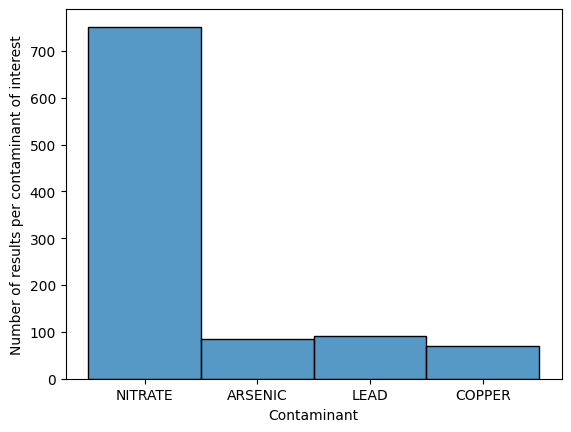

In [30]:
# Plot visual for number of test results per contaminant
# Plot histogram
sns.histplot(data=data, x="CONTAMDESC")

# Change x-axis label
plt.xlabel("Contaminant")

# Change y-axis label
plt.ylabel("Number of results per contaminant of interest")

<blockquote> 2. How many test results do we see at each PWS ID location? Over 350 test results come from a single location - ID 4500773.

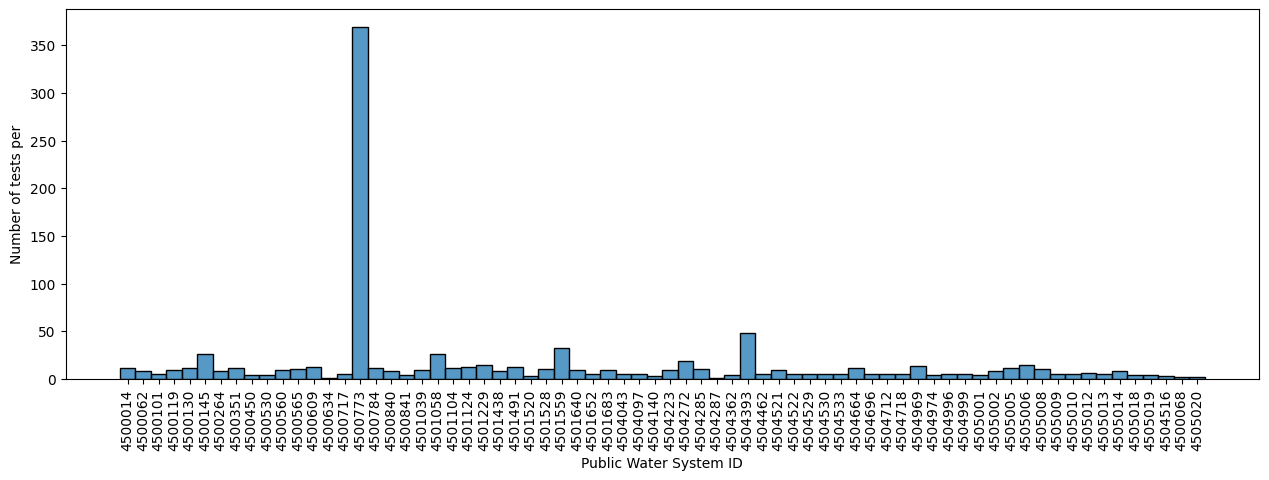

In [31]:
# Plot visual for number of test results per test location
# Convert PWSID dtype to string
data["PWSID"] = data.PWSID.astype(str)

# Specify plot size
plt.figure(figsize=(15.4, 4.8))

# Plot histogram
sns.histplot(data=data, x="PWSID")

# Change x-axis label
plt.xlabel("Public Water System ID")

# Change y-axis label
plt.ylabel("Number of tests per")

# Rotate x-axis labels
plt.xticks(rotation=90)

plt.show()

<blockquote> 3. What are the details of location ID 4500773 where over 350 of our test results come from? 4. Are the large amount of nitrate tests related to this location? This test location is in a city called Lake Worth Beach. That's where I live! Just about 350 of the test results from 4500773 are for nitrate tests. That means almost half of all nitrate tests in the county are from the Lake Worth Beach testing location.

In [32]:
loc_df[loc_df["PWSID"]==4500773]

,Unnamed: 0,PWSID,MAILINGNAME,ADDRESS1,ADDRESS2,CITY,SYSTEMSTATE,ZIP,ZIPFOUR,Latitude,...,Number,Street,Unit Type,Unit Number,City,State,County,Zip,Country,Source
18,2782,4500773,LAKE WORTH BEACH UTILITIES,1900 2ND AVE NORTH,NaN,LAKE WORTH BEACH,FL,33461,4298.0,26.61919,...,1900.0,2nd Ave N,NaN,NaN,Lake Worth Beach,FL,Palm Beach County,33461,US,Palm Beach (Public Domain Palm Beach County)


Text(0, 0.5, 'Number of results per contaminant of interest')

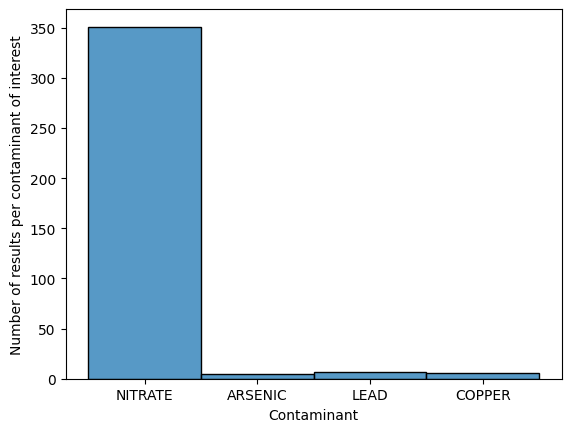

In [36]:
# Plot visual for number of test results per contaminant at PWS ID 4500773
# Plot histogram
sns.histplot(data=data[data["PWSID"]=='4500773'], x="CONTAMDESC")

# Change x-axis label
plt.xlabel("Contaminant")

# Change y-axis label
plt.ylabel("Number of results per contaminant of interest")



In [34]:
data[(data["PWSID"]=='4500773') & (data["CONTAMDESC"]=="NITRATE")]

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE
22,4500773,1040,NITRATE,0.000,MG/L,10.0000,2019-02-11
25,4500773,1040,NITRATE,0.000,MG/L,10.0000,2019-02-15
26,4500773,1040,NITRATE,0.000,MG/L,10.0000,2019-02-15
161,4500773,1040,NITRATE,0.055,MG/L,10.4999,2020-01-09
162,4500773,1040,NITRATE,0.056,MG/L,10.4999,2020-01-09
...,...,...,...,...,...,...,...
752,4500773,1040,NITRATE,0.360,MG/L,10.4999,2022-03-07
753,4500773,1040,NITRATE,0.240,MG/L,10.4999,2022-03-23
754,4500773,1040,NITRATE,0.180,MG/L,10.4999,2022-03-23
756,4500773,1040,NITRATE,0.074,MG/L,10.4999,2022-03-22


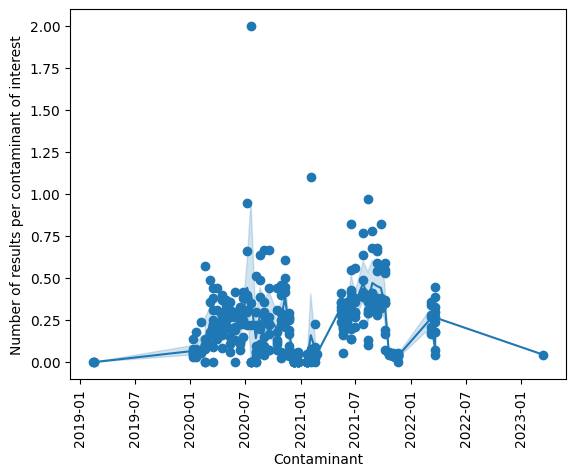

In [37]:
# Plot visual for nitrate results at Lake Worth PWSID 4500773
# Plot lineplot
sns.lineplot(data=data[(data["PWSID"]=='4500773') & (data["CONTAMDESC"]=="NITRATE")], x="SAMPLEDATE", y="RESULTS")
plt.scatter(data=data[(data["PWSID"]=='4500773') & (data["CONTAMDESC"]=="NITRATE")], x="SAMPLEDATE", y="RESULTS")

# Change x-axis label
plt.xlabel("Contaminant")

# Change y-axis label
plt.ylabel("Number of results per contaminant of interest")

# Rotate x-axis scale labels 
plt.xticks(rotation=90)

plt.show()

<blockquote> 5. Is there some anomoly with the data here-- perhaps a repeated record or null values? There are no null values. The maximum number of repeats at the Lake Worth Beach location is six tests on three dates. The maximum number of repeats in all other locations is three tests on four dates. These discrepancies don't strike me as wildly out-of-the-ordinary, so I will assume that errors in the data are not the reason we see so much nitrate testing at a single location.

In [38]:
pd.set_option('display.max_rows', 1000)
data[(data["PWSID"]=='4500773') & (data["CONTAMDESC"]=="NITRATE") & (data["RESULTS"]<.2)].value_counts()

PWSID    CONTAMCODE  CONTAMDESC  RESULTS  UOM   MCL      SAMPLEDATE
4500773  1040        NITRATE     0.000    MG/L  10.4999  2020-12-09    6
                                                         2020-12-21    6
                                                         2021-01-22    6
                                                         2020-07-20    4
                                 0.036    MG/L  10.4999  2021-02-03    3
                                 0.120    MG/L  10.4999  2020-06-12    2
                                 0.180    MG/L  10.4999  2022-03-23    2
                                 0.140    MG/L  10.4999  2021-06-17    2
                                 0.100    MG/L  10.4999  2020-02-19    2
                                 0.038    MG/L  10.4999  2021-11-04    2
                                 0.000    MG/L  10.0000  2019-02-15    2
                                                10.4999  2020-08-05    2
                                                        

In [ ]:
# Plot visual for nitrate results at all locations other than 4500773

# Create df of results excluding those at 4500773
data_dropped_4500773 = data.drop(data[data["PWSID"]=="4500773"].index)

# Plot lineplot
sns.lineplot(data=data_dropped_4500773, x="SAMPLEDATE", y="RESULTS")
plt.scatter(data=data_dropped_4500773, x="SAMPLEDATE", y="RESULTS")

# Change x-axis label
plt.xlabel("Contaminant")

# Change y-axis label
plt.ylabel("Number of results per contaminant of interest")

# Rotate x-axis scale labels 
plt.xticks(rotation=90)

plt.show()


In [42]:
data_dropped_4500773 = data[data["PWSID"]!="4500773"]
data_dropped_4500773[(data_dropped_4500773["CONTAMDESC"]=="NITRATE") & (data_dropped_4500773["RESULTS"]<.2)].value_counts()

PWSID    CONTAMCODE  CONTAMDESC  RESULTS  UOM   MCL      SAMPLEDATE
4504393  1040        NITRATE     0.0000   MG/L  10.0000  2019-05-20    3
                                                10.4999  2022-06-13    3
                                                         2023-06-12    3
4501559  1040        NITRATE     0.0000   MG/L  10.0000  2019-01-10    3
4504223  1040        NITRATE     0.0000   MG/L  10.0000  2019-08-20    2
4504664  1040        NITRATE     0.0000   MG/L  10.0000  2019-12-10    2
4500560  1040        NITRATE     0.0000   MG/L  10.0000  2019-08-20    2
4501058  1040        NITRATE     0.0000   MG/L  10.0000  2019-02-21    2
4501104  1040        NITRATE     0.0000   MG/L  10.0000  2019-03-18    2
                                                         2019-08-15    2
                                                10.4999  2022-03-17    2
4501559  1040        NITRATE     0.1000   MG/L  10.4999  2023-01-05    2
4500145  1040        NITRATE     0.0000   MG/L  10.0000 

<Axes: xlabel='count', ylabel='Count'>

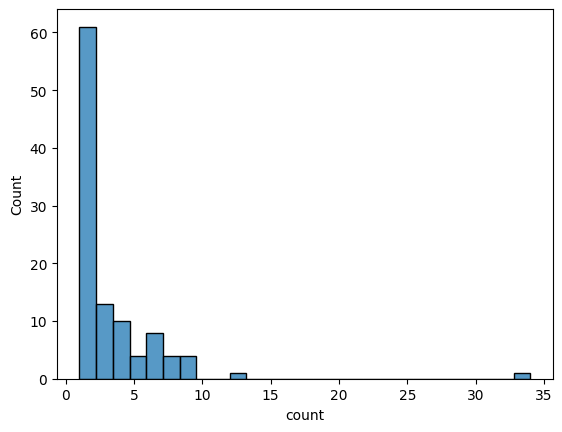

In [41]:
sns.histplot(data=data[(data["PWSID"]=='4500773') & (data["CONTAMDESC"]=="NITRATE")]["RESULTS"].value_counts())



<blockquote>6. Violation! It took everything in me to not immediately jump to my burning question -- are there any test reults that exceed maximum contaminant levels? Yes, for lead! Of the nearly thousand tests we have over 5 years for four contaminants, there has been only one result in excess of its maximum limit, in 2020. That seems pretty good to me. This elevated lead level comes from a test at the same Lake Worth Beach location we have been exploring, ID 4500773. Upon further inspection, results of all other lead tests at this location are zero.

In [43]:
data[data["RESULTS"] > data["MCL"]]

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE
183,4500773,1030,LEAD,0.19,MG/L,0.0154,2020-02-07


In [44]:
loc_df[loc_df["PWSID"] == 4500773]

,Unnamed: 0,PWSID,MAILINGNAME,ADDRESS1,ADDRESS2,CITY,SYSTEMSTATE,ZIP,ZIPFOUR,Latitude,...,Number,Street,Unit Type,Unit Number,City,State,County,Zip,Country,Source
18,2782,4500773,LAKE WORTH BEACH UTILITIES,1900 2ND AVE NORTH,NaN,LAKE WORTH BEACH,FL,33461,4298.0,26.61919,...,1900.0,2nd Ave N,NaN,NaN,Lake Worth Beach,FL,Palm Beach County,33461,US,Palm Beach (Public Domain Palm Beach County)


In [48]:
data[(data["PWSID"]=='4500773') & (data["CONTAMDESC"] == "LEAD")]

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE
24,4500773,1030,LEAD,0.00,MG/L,0.0000,2019-02-15
183,4500773,1030,LEAD,0.19,MG/L,0.0154,2020-02-07
501,4500773,1030,LEAD,0.00,MG/L,0.0154,2021-05-21
582,4500773,1030,LEAD,0.00,MG/L,0.0154,2021-02-23
622,4500773,1030,LEAD,0.00,MG/L,0.0154,2021-08-26
755,4500773,1030,LEAD,0.00,MG/L,0.0154,2022-03-22
883,4500773,1030,LEAD,0.00,MG/L,0.0154,2023-03-16


I notice here that the first listed record has 0.0000 as the MCL, while the rest of the records have 0.0154. 

The United States Enviornmental Protection Agency (EPA) sets maximum contaminant levels, and lists them at https://www.epa.gov/ground-water-and-drinking-water/national-primary-drinking-water-regulations. The EPA also identifies goal levels, that water systems should aspire to. Let's add the EPA's MCLs and MCLGs (goals) to our dataframe.

In [50]:
# Add MCLs and MCL goals according to EPA to data. From https://www.epa.gov/ground-water-and-drinking-water/national-primary-drinking-water-regulations
# Define function to make MCL assignment
def epa_mcl(contaminant):
    if contaminant == "LEAD":
        return 0.015
    if contaminant == "ARSENIC":
        return 0.010
    if contaminant == "NITRATE":
        return 10
    if contaminant == "COPPER":
        return 1.3
    
# Define function to make MCL goal assignment
def epa_mclg(contaminant):
    if contaminant == "LEAD":
        return 0
    elif contaminant == "ARSENIC":
        return 0
    elif contaminant == "NITRATE":
        return 10
    elif contaminant == "COPPER":
        return 1.3
    
# Apply above fuctions to CONTAMDESC column to create two new columns, EPA_MCL and EPA_MCLG
data["EPA_MCL"] = data["CONTAMDESC"].apply(epa_mcl)
data["EPA_MCLG"] = data["CONTAMDESC"].apply(epa_mclg)

Now that we have updated our data with accurate MCLs provided by the EPA, let's visualize test results for lead at the Lake Worth Beach location where we found a violation according to MCLs provided by the DEP. 

<blockquote>7. Is the result we idenfitied still in violation? It sure is. <br>8. Are there any additional violations according to EPA? Good news, no other violations!

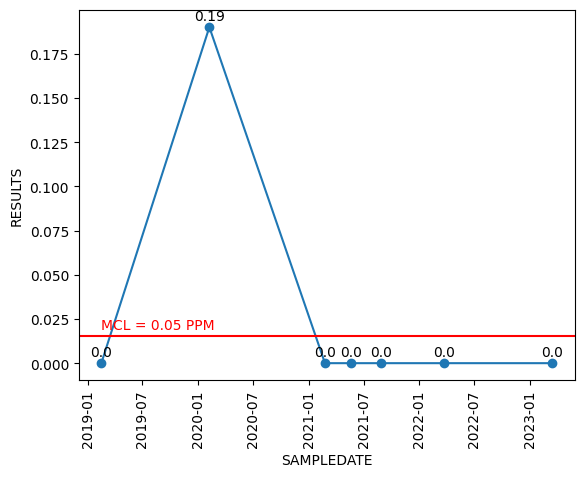

In [58]:
# Build plot of all lead sample results from location PWSID '4500773'

# Create line plot
sns.lineplot(data=data[(data["PWSID"] == '4500773') & (data["CONTAMDESC"] == "LEAD")], x="SAMPLEDATE", y="RESULTS")

# Add points for visual
plt.scatter(data=data[(data["PWSID"] == '4500773') & (data["CONTAMDESC"] == "LEAD")], x="SAMPLEDATE", y="RESULTS")

# Define x and y to annotate scatter plot points with result value
x = [x for x in data[(data["PWSID"] == '4500773') & (data["CONTAMDESC"] == "LEAD")]["SAMPLEDATE"]]
y = [y for y in data[(data["PWSID"] == '4500773') & (data["CONTAMDESC"] == "LEAD")]["RESULTS"]]

# Annotate scatter plot points
for i, label in enumerate(y):
    plt.annotate(label, (x[i], y[i] + 0.004), ha='center')

# Plot line to represent MCL threshold
plt.axhline(y=0.0154, color='red', linestyle='-')

# Label MCL threshold line
plt.text(x=x[0], y=0.0154+0.004, s="MCL = 0.05 PPM", color='red')

# Rotate x-ticks
plt.xticks(rotation=90)

# Show plot
plt.show()

In [51]:
data[data["RESULTS"] > data["EPA_MCL"]]

,PWSID,CONTAMCODE,CONTAMDESC,RESULTS,UOM,MCL,SAMPLEDATE,EPA_MCL,EPA_MCLG
183,4500773,1030,LEAD,0.19,MG/L,0.0154,2020-02-07,0.015,0.0


<blockquote> 4. How about results that don't exceed MCL but do exceed the EPA's goal levels? There are 18 test results that exceed the EPA's goal levels for drinking water. Ten are for lead levels, and eight are for arsenic levels.

Text(0, 0.5, 'Number of results above EPA MCL goal levels')

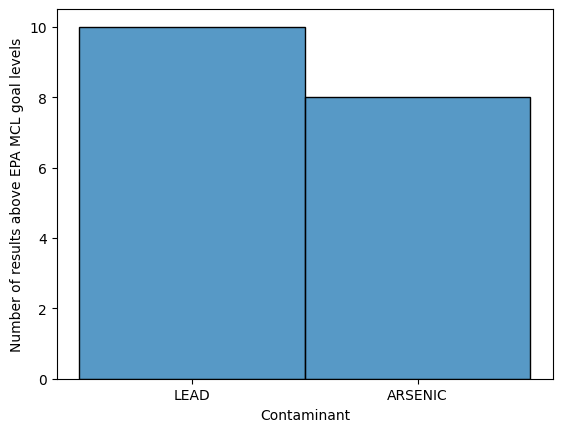

In [59]:
contams_elevated = data[data["RESULTS"] > data["EPA_MCLG"]]

sns.histplot(data=contams_elevated, x="CONTAMDESC")
plt.xlabel("Contaminant")
plt.ylabel("Number of results above EPA MCL goal levels")

Let's look at results over time for all contaminant levels.

Text(2020-12-02, -0.008, 'MCLG = 0 PPM')

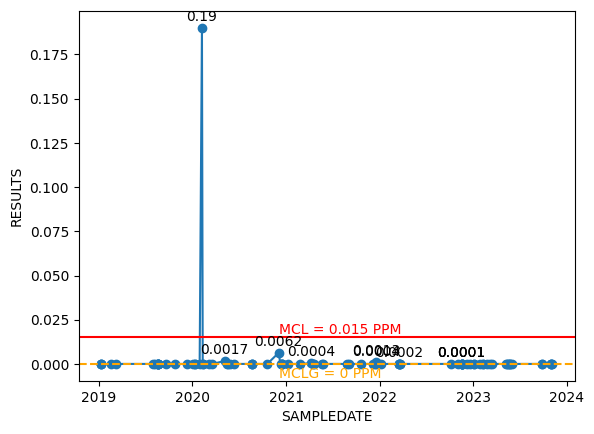

In [60]:
# Visual plot of all lead results in data
# Create new dataframe of only lead results
lead_data = data[data["CONTAMDESC"] == "LEAD"]
lead_data_elevated = lead_data[lead_data["RESULTS"]>0]

# Create lineplot
lead_plot = sns.lineplot(data=lead_data, x="SAMPLEDATE", y="RESULTS")

# Add scatter plot points for visual
lead_plot.scatter(data=lead_data, x="SAMPLEDATE", y="RESULTS")

# Define x and y to annotate scatter plot points with result value
x = [x for x in lead_data_elevated["SAMPLEDATE"]]
y = [y for y in lead_data_elevated["RESULTS"]]

# Annotate scatter plot points
for i, label in enumerate(y):
   lead_plot.annotate(label, (x[i], y[i] + 0.004), ha='center')

# Plot line to represent MCL threshold
lead_plot.axhline(y=.015, color='red', linestyle='-')

# Label MCL threshold line
lead_plot.text(x=x[1], y=.017, s="MCL = 0.015 PPM", color='red')

# Plot line to represent MCL goal threshold 
lead_plot.axhline(y=0, color='orange', linestyle='--')

# Label MCLG threshold line
lead_plot.text(x=x[1], y=-.008, s="MCLG = 0 PPM", color='orange')

IndexError: list index out of range

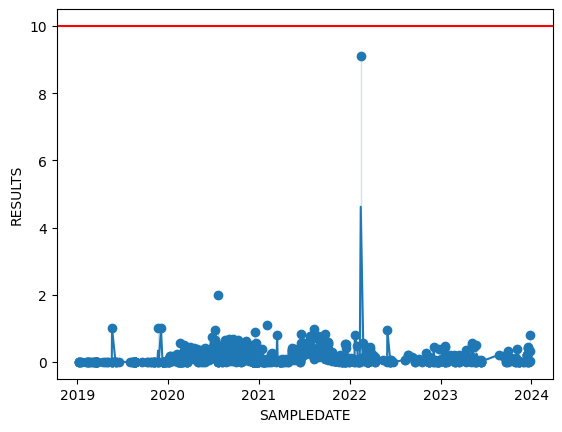

In [61]:
# Visual plot of all nitrate results in data

# Create new dataframe of only nitrate results
nit_data = data[data["CONTAMDESC"] == "NITRATE"]
nit_data_elevated = nit_data[nit_data["RESULTS"]>10]

# Create lineplot
nit_plot = sns.lineplot(data=nit_data, x="SAMPLEDATE", y="RESULTS")

# Add scatter plot points for visual
nit_plot.scatter(data=nit_data, x="SAMPLEDATE", y="RESULTS")

# Define x and y to annotate scatter plot points with result value
x = [x for x in nit_data_elevated["SAMPLEDATE"]]
y = [y for y in nit_data_elevated["RESULTS"]]

# Annotate scatter plot points
#for i, label in enumerate(y):
#   nit_plot.annotate(label, (x[i], y[i] + 0.004), ha='center')

# Plot line to represent MCL threshold
nit_plot.axhline(y=10, color='red', linestyle='-')

# Label MCL threshold line
nit_plot.text(x=x[1], y=10.05, s="MCL = 10.0 PPM", color='red')

# Plot line to represent MCL goal threshold 
nit_plot.axhline(y=10, color='orange', linestyle='--')

# Label MCLG threshold line
nit_plot.text(x=x[1], y=10-0.5, s="MCLG = 10.0 PPM", color='orange')

Text(2020-12-02, 0.0007, 'MCLG = 0 PPB')

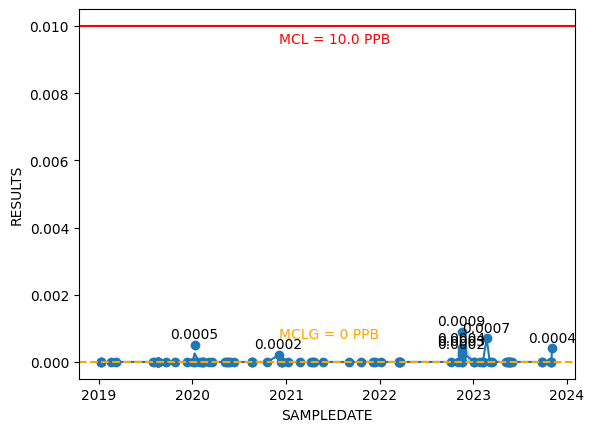

In [62]:
# Visualize plot of arsenic levels only
# Create subset of data for arsenic test results
ars_data = data[data["CONTAMDESC"] == "ARSENIC"]

# Create subset of arsenic results greater than MCLG (0)
ars_data_elevated = ars_data[ars_data["RESULTS"]>0]

# Plot lineplot 
ars_plot = sns.lineplot(data=ars_data, x="SAMPLEDATE", y="RESULTS")

# Add scatter points for visual
ars_plot.scatter(data=ars_data, x="SAMPLEDATE", y="RESULTS")

#Define x and y to annotate scatter plot points with result value
x = [x for x in ars_data_elevated["SAMPLEDATE"]]
y = [y for y in ars_data_elevated["RESULTS"]]

# Annotate scatter plot points
for i, label in enumerate(y):
    ars_plot.annotate(label, (x[i], y[i] + 0.0002), ha='center')

# Plot line to represent MCL threshold
ars_plot.axhline(y=0.010, color='red', linestyle='-')

# Label MCL threshold line
ars_plot.text(x=x[0], y=0.0095, s="MCL = 10.0 PPB", color='red')

# Plot line to represent MCL goal threshold 
ars_plot.axhline(y=0, color='orange', linestyle='--')

# Label MCLG threshold line
ars_plot.text(x=x[0], y=0.0007, s="MCLG = 0 PPB", color='orange')

Text(2020-02-11, 1.25, 'MCLG = 0 PPB')

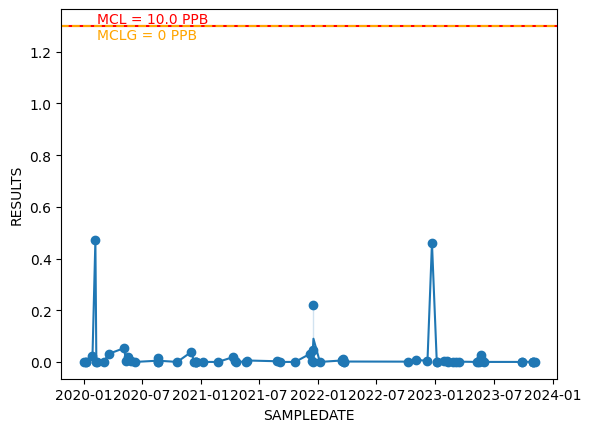

In [63]:
cop_data = data[data["CONTAMDESC"] == "COPPER"]

cop_plot = sns.lineplot(data=cop_data, x="SAMPLEDATE", y="RESULTS")

# Add points for visual
cop_plot.scatter(data=cop_data, x="SAMPLEDATE", y="RESULTS")


# Define x and y to annotate scatter plot points with result value
x = [x for x in cop_data["SAMPLEDATE"]]
y = [y for y in cop_data["RESULTS"]]

# Annotate scatter plot points
#for i, label in enumerate(y):
#    cop_plot.annotate(label, (x[i], y[i] + 0.05), ha='center', rotation=90)

# Plot line to represent MCL threshold
cop_plot.axhline(y=1.3, color='red', linestyle='-')

# Label MCL threshold line
cop_plot.text(x=x[1], y=1.3+0.01, s="MCL = 10.0 PPB", color='red')

# Plot line to represent MCL goal threshold 
cop_plot.axhline(y=1.3, color='orange', linestyle='--')

# Label MCLG threshold line
cop_plot.text(x=x[1], y=1.25, s="MCLG = 0 PPB", color='orange')

In [67]:
lat_lon_df = loc_df[["PWSID", "Latitude", "Longitude"]]

In [82]:
# Convert column PWSID in data df to int64
data["PWSID"] = data.PWSID.astype(int)

# Merge location data with data df
data_merged=data.merge(right=lat_lon_df, how='inner',on="PWSID", right_index=False)

In [76]:
# Create a list of PWSID testing locations for which we have test results in data
marker_locations = lat_lon_df[lat_lon_df["PWSID"].isin(data["PWSID"].unique())].reset_index(drop=True)
marker_locations.sort_values("PWSID")

,PWSID,Latitude,Longitude
0,4500014,26.654840,-80.237962
1,4500062,26.583764,-80.107277
2,4500068,26.595179,-80.097179
3,4500101,26.466699,-80.179144
4,4500119,26.663960,-80.716170
5,4500130,26.351022,-80.090630
6,4500145,26.645895,-80.430269
7,4500264,26.491835,-80.125790
8,4500351,26.452041,-80.075363
9,4500450,26.855866,-80.300270


In [81]:
# Create a map with marker locations
import folium

# Initialize map where location is center of Palm Beach County
map = folium.Map(location=(26.6515,-80.2767), zoom_start=10)

# Add markers for PWSID testing locations to map
for i in range(0, marker_locations.shape[0]):
    folium.Marker(
        location=(marker_locations.iloc[i]["Latitude"], marker_locations.iloc[i]["Longitude"]),
        popup=[marker_locations.iloc[i]["PWSID"]]
    ).add_to(map)

map